## Bayesian Interval Estimation using Markov Chain Monte Carlo  

In this example we compute a Bayesian credible interval using the Markov Chain Monte Carlo method with the RooStats  `MCMCCalculator` class.

The interval is obtained from the Posterior probability function, which is computed from the Bayes theorem using a 
Markov chain Monte Carlo

$$P( \mu | x ) = \frac { \int L (x | \mu , \nu ) \Pi ( \mu, \nu ) d\nu } { \int \int L (x | \mu , \nu ) \Pi ( \mu, \nu ) d \mu d\nu} $$

The output consists of a set of data points (the MC chain) which is distributed according to the posterior distribution. 
This calculator can work with many parameter of interests and many nuisance parameters.


In [1]:
//%jsroot on

In [2]:
using namespace RooStats;

In [3]:
MCMCInterval * interval = nullptr;
MCMCIntervalPlot * plot = nullptr; 
ProposalFunction * proposalFunc = nullptr;
RooAbsPdf * priorPdf = nullptr;
TStopwatch tw;

##### 1. Reading the model (Workspace) from input file

First part is just to get the workspace from the input file and retrieve the model and the data set

In [4]:
//TString fileName = "CountingModelVaryingB.root";
TString fileName = "HiggsBinModel.root";
TString workspaceName = "w";
TString modelConfigName = "ModelConfig";
TString dataName = "data";
TString integrationType = "";  

In [5]:
auto file = TFile::Open(fileName);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [6]:
auto w =  (RooWorkspace*) file->Get(workspaceName);
w->Print();
auto mc = (RooStats::ModelConfig*) w->obj(modelConfigName);
auto  data = w->data(dataName);
mc->SetParametersOfInterest(RooArgSet(*w->var("nsignal"),*w->var("mass")));
auto poi = (RooRealVar*) mc->GetParametersOfInterest()->first();  // get POI 
w->var("mass")->setConstant(false);


RooWorkspace(w) w contents

variables
---------
(a1,a2,mass,nbackground,nsignal,width,x)

p.d.f.s
-------
RooExponential::bmodel[ x=z c=1 ] = 0.000354025
RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000350859
RooGaussian::smodel[ x=x mean=mass sigma=width ] = 1.8233e-12

functions
--------
RooFormulaVar::z[ actualVars=(a1,a2,x) formula="-(a1*x/100.+a2*(x/100.)^2)" ] = -7.94614

datasets
--------
RooDataHist::data(x)

named sets
----------
ModelConfig_NuisParams:(a1,a2,nbackground)
ModelConfig_Observables:(x)
ModelConfig_POI:(nsignal)
nuisParams:(a1,a2,nbackground)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



In [7]:
// constraint nuisance parameters to +/- 10 sigma of their best fit
a1 = w->var("a1");
a1->setMin(a1->getVal()-10*a1->getError());
a1->setMax(a1->getVal()+10*a1->getError());

a2 = w->var("a2");
a2->setMin(a2->getVal()-10*a2->getError());
a2->setMax(a1->getVal()+10*a2->getError());

#### 2. Create and configure the `MCMCCalculator` class

In [8]:
RooStats::MCMCCalculator mcmcCalc(*data,*mc);

##### Set a prior PDF, otherwise by default a uniform prior is used

We create here a Prior probability density function for the parameter of interest. 

In [9]:
//priorPdf = (RooAbsPdf*) w->factory("EXPR::priorPdf('1./sqrt(s+b)',s)");
//priorPdf = new RooGenericPdf("priorPdf","priorPdf","1./(s)",RooArgList(*w->var("s")));

If a prior pdf has been created, set it in the calculator. Otherwise, in case no prior is set, a default uniform prior in the parameters is used. 

In [10]:
if (priorPdf) mcmcCalc.SetPriorPdf(*priorPdf);
// this is needed to normalize the prior pdf
RooAbsReal::defaultIntegratorConfig()->method1D().setLabel("RooAdaptiveGaussKronrodIntegrator1D");

##### Set the interval Confidence Level

In [11]:
mcmcCalc.SetConfidenceLevel(0.68);

##### Set the type of interval.

One can have : 

- shortest interval
- central interval (equal fraction of probability in the tails) 
- lower limit    
- upper limit  

The distinction between lower/upper and central interval is done by setting the left side tail fraction of probability.

Set the type of interval, default is shortest intervals

In [12]:
//mcmcCalc.SetLeftSideTailFraction(0.5);  // for central intervals
//mcmcCalc.SetLeftSideTailFraction(0.);   // for upper limits

##### Set proposal function and configure Markov-Chain Monte Carlo method

In [13]:
proposalFunc = new RooStats::SequentialProposal(0.1);
mcmcCalc.SetProposalFunction(*proposalFunc);

In [14]:
mcmcCalc.SetNumIters(5000000);         // Metropolis-Hastings algorithm iterations
mcmcCalc.SetNumBurnInSteps(1000);       // first N steps to be ignored as burn-in

In [15]:
// define a restricted range for the parameter of interest
//w->var("s")->setMax(20);
mcmcCalc.SetNumBins(100);

#### 3. Compute the interval

Run the calculator and compute the interval from the posterior. 

In [16]:
tw.Start();
interval = mcmcCalc.GetInterval();
tw.Print();

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bmodel_Int[x]) using numeric integrator RooAdaptiveGaussKronrodIntegrator1D to calculate Int(x)
Metropolis-Hastings progress: ....................................................................................................
[#1] INFO:Eval -- Proposal acceptance rate: 5.9515%
[#1] INFO:Eval -- Number of steps in chain: 297575
Real time 0:02:22, CP time 142.310


In [17]:
cout << 100*mcmcCalc.ConfidenceLevel() << "% interval is : [" 
    << interval->LowerLimit(*poi) << ", "<< interval->UpperLimit(*poi) <<"] "<<endl;

68% interval is : [115, 395] 


In [18]:
plot = new RooStats::MCMCIntervalPlot(*interval);

In [19]:
//plot->Draw("LEGO" ); gPad->Draw();

In [20]:
auto hposterior = (TH2*) interval->GetPosteriorHist();

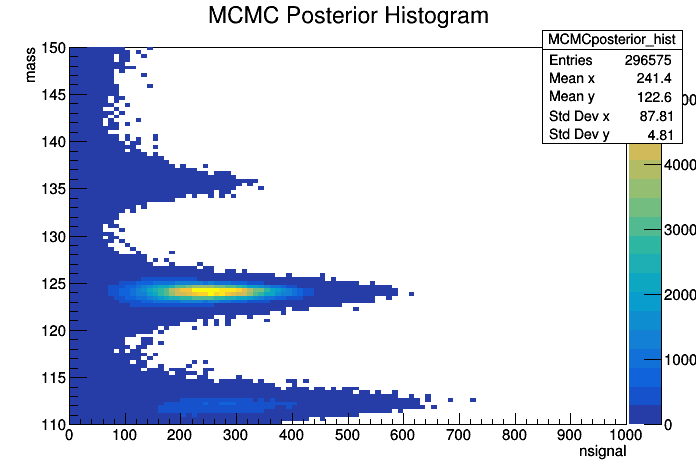

In [21]:
c1 = new TCanvas(); 
hposterior->Draw("COL Z");
c1->Draw();

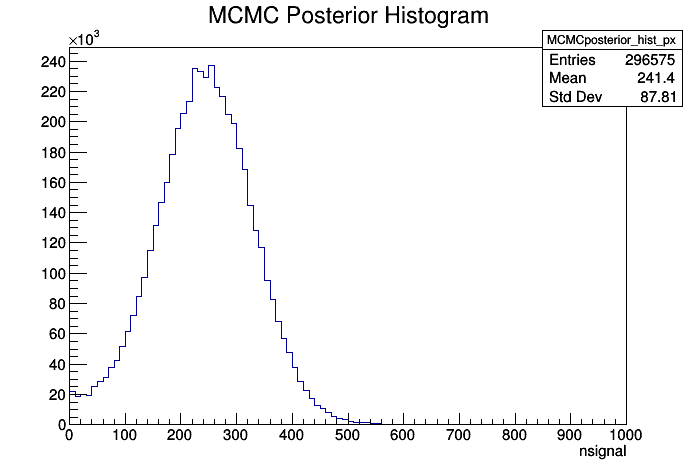

In [22]:
hsig = hposterior->ProjectionX(); 
hsig->Draw("HIST");
gPad->Draw();

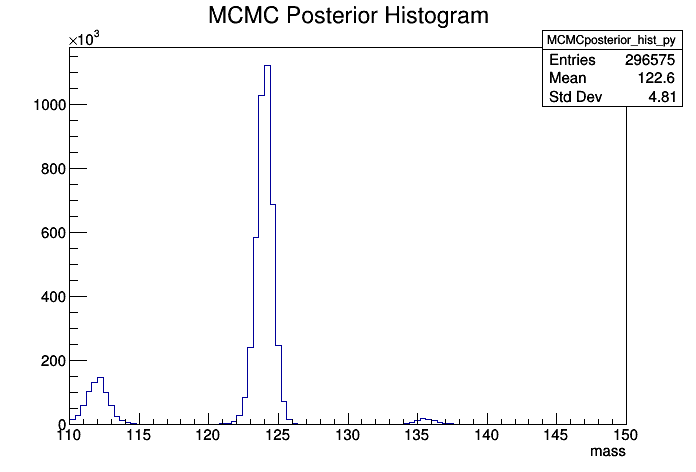

In [23]:
hmass = hposterior->ProjectionY(); 
hmass->Draw("HIST");
gPad->Draw();